In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [9]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
latest_minus_12m = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(latest_minus_12m)

2016-08-23


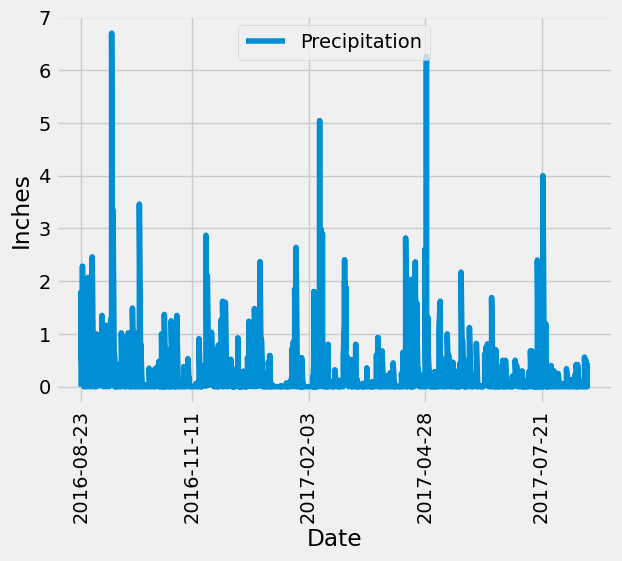

In [15]:
# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= latest_minus_12m).order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_last_12m = pd.DataFrame(query_results).dropna()

# Sort the dataframe by date
prcp_last_12m.sort_values('date')

x_ticks = prcp_last_12m['date'][::470]

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_last_12m['date'], prcp_last_12m['prcp'], label="Precipitation")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(x_ticks, rotation='vertical')
plt.legend(loc="upper center")

plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_dict = {'count': prcp_last_12m['prcp'].count(),
              'mean': prcp_last_12m['prcp'].mean(), 
              'std': prcp_last_12m['prcp'].std(), 
              'min': prcp_last_12m['prcp'].min(),
              '25%': prcp_last_12m['prcp'].quantile(.25),
              '50%': prcp_last_12m['prcp'].quantile(.5,),
              '75%': prcp_last_12m['prcp'].quantile(.75),
              'max': prcp_last_12m['prcp'].max()
             }

summary_df = pd.DataFrame.from_dict(summary_dict, orient='index', columns=['percipitation'])
summary_df


,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Stations.id)).all()

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurements.station, func.count(Measurements.id))\
.group_by(Measurements.station)\
.order_by(func.count(Measurements.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).filter(Measurements.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_tobs = session.query(Measurements.tobs).filter(Measurements.station == 'USC00519281').filter(Measurements.date > latest_minus_12m).all()
USC00519281_tobs_df = pd.DataFrame(USC00519281_tobs)

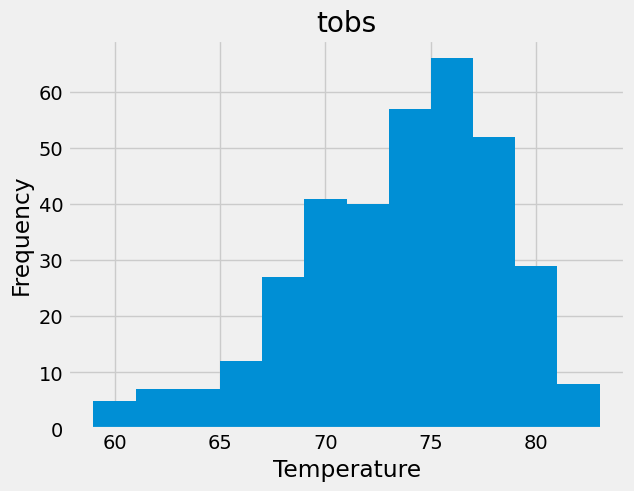

In [21]:
USC00519281_tobs_df.hist(bins=12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel('Frequency')
plt.show()

# Close Session

In [22]:
# Close Session
session.close()